<a href="https://colab.research.google.com/github/AhPro7/Natural-Language-Processing-with-Transformers-Building-Language-Applications-with-Hugging-Face/blob/main/Text_Classification_using_transformers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [142]:
! pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [143]:
from datasets import list_datasets
all_datasets = list_datasets()

In [144]:
print(f"There are {len(all_datasets)} datasets currently available on the Hub")
print(f"The first 10 are: {all_datasets[:10]}")

There are 7151 datasets currently available on the Hub
The first 10 are: ['acronym_identification', 'ade_corpus_v2', 'adversarial_qa', 'aeslc', 'afrikaans_ner_corpus', 'ag_news', 'ai2_arc', 'air_dialogue', 'ajgt_twitter_ar', 'allegro_reviews']


In [145]:
# get the dataset with "emotion" name from above list

from datasets import load_dataset
emotions = load_dataset("emotion")

Using custom data configuration default
Reusing dataset emotion (/root/.cache/huggingface/datasets/emotion/default/0.0.0/348f63ca8e27b3713b6c04d723efe6d824a56fb3d1449794716c0f0296072705)


  0%|          | 0/3 [00:00<?, ?it/s]

In [146]:
# Take a look at the data

print(emotions,end="\n \n \n")
print('type of varible') 
type(emotions)

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})
 
 
type of varible


datasets.dataset_dict.DatasetDict

In [147]:
#split the dic to 3 datasets

train_ds = emotions["train"]
val_ds = emotions["validation"]
test_ds = emotions["test"]

In [148]:
print(train_ds)
print(train_ds[0])

Dataset({
    features: ['text', 'label'],
    num_rows: 16000
})
{'text': 'i didnt feel humiliated', 'label': 0}


In [149]:
# let's see features of  train data 
train_ds.features

{'label': ClassLabel(num_classes=6, names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'], id=None),
 'text': Value(dtype='string', id=None)}

In [150]:
# let's change the datasets to dataframes 
import pandas as pd

emotions.set_format(type="pandas")
df = emotions["train"][:]
df.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


In [151]:
# chanage the labels from just number to it's name

def label_int2str(row):
  '''
  row : from dataset
  '''
  return emotions["train"].features["label"].int2str(row)

df["label_name"] = df["label"].apply(label_int2str)

df.head()

,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


In [152]:
# let's add good theme and discover more in data

! pip install mplcyberpunk


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [153]:
import matplotlib.pyplot as plt
import mplcyberpunk

plt.style.use("cyberpunk")


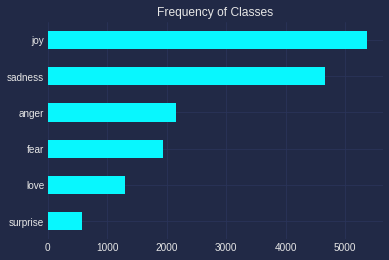

In [154]:
df["label_name"].value_counts(ascending=True).plot.barh()
plt.title("Frequency of Classes")
plt.show()

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


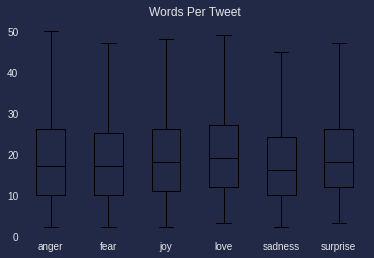

In [155]:
# How Long Are Our Tweets?

df["Words Per Tweet"] = df["text"].str.split().apply(len)
df.boxplot("Words Per Tweet", by="label_name", grid=False,
showfliers=False, color="black")
plt.suptitle("")
plt.xlabel("")
# mplcyberpunk.add_glow_effects()

plt.show()

In [156]:
# i think i will not use dataframe any more past cells just to see some info i need like classes max lenght or "number of words"
# let's back
emotions.reset_format()

In [157]:
# From Text to Tokens ==> to fit the model
# i will use Subword Tokenization

! pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [158]:

from transformers import AutoTokenizer
model_ckpt = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

In [159]:
from transformers import DistilBertTokenizer
distilbert_tokenizer = DistilBertTokenizer.from_pretrained(model_ckpt)

In [160]:
def tokenize(batch):
  return tokenizer(batch["text"], padding=True, truncation=True)

In [161]:
print(tokenize(emotions["train"][:2]))

{'input_ids': [[101, 1045, 2134, 2102, 2514, 26608, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 1045, 2064, 2175, 2013, 3110, 2061, 20625, 2000, 2061, 9636, 17772, 2074, 2013, 2108, 2105, 2619, 2040, 14977, 1998, 2003, 8300, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}


In [162]:
emotions_encoded = emotions.map(tokenize, batched=True, batch_size=None)

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [163]:
print(emotions_encoded["train"].column_names)

['text', 'label', 'input_ids', 'attention_mask']


# Training a Text Classifier
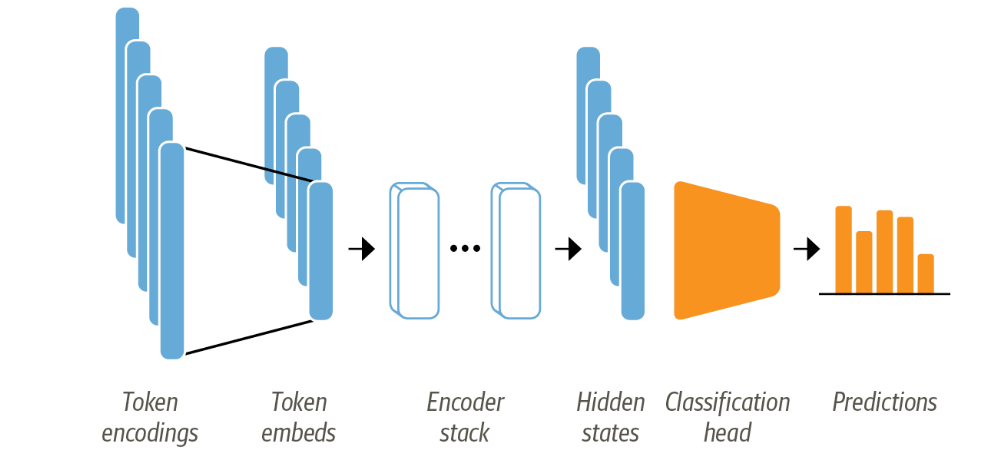

# Using pretrained models
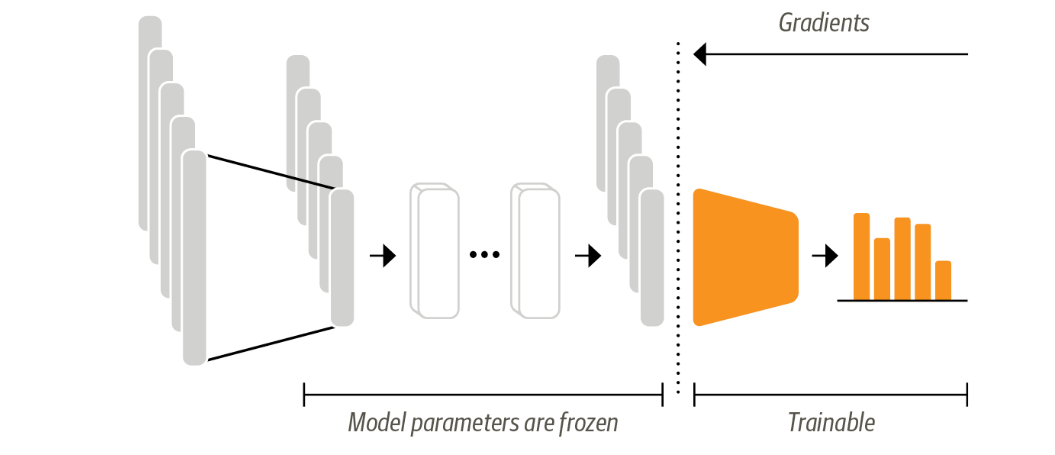

In [164]:
import torch
model_ckpt = "distilbert-base-uncased"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModel.from_pretrained(model_ckpt).to(device)

In [165]:
# Extracting the last hidden states

text = "this is a test"
inputs = tokenizer(text, return_tensors="pt")
print(f"Input tensor shape: {inputs['input_ids'].size()}")

Input tensor shape: torch.Size([1, 6])


In [166]:
inputs = {k:v.to(device) for k,v in inputs.items()}
with torch.no_grad():
  outputs = model(**inputs)
print(outputs)

BaseModelOutput(last_hidden_state=tensor([[[-0.1565, -0.1862,  0.0528,  ..., -0.1188,  0.0662,  0.5470],
         [-0.3575, -0.6484, -0.0618,  ..., -0.3040,  0.3508,  0.5221],
         [-0.2772, -0.4459,  0.1818,  ..., -0.0948, -0.0076,  0.9958],
         [-0.2841, -0.3917,  0.3753,  ..., -0.2151, -0.1173,  1.0526],
         [ 0.2661, -0.5094, -0.3180,  ..., -0.4203,  0.0144, -0.2149],
         [ 0.9441,  0.0112, -0.4714,  ...,  0.1439, -0.7288, -0.1619]]],
       device='cuda:0'), hidden_states=None, attentions=None)


In [167]:
outputs.last_hidden_state.size()

torch.Size([1, 6, 768])

In [168]:
outputs.last_hidden_state[:,0].size()

torch.Size([1, 768])

In [169]:
def extract_hidden_states(batch):
# Place model inputs on the GPU
  inputs = {k:v.to(device) for k,v in batch.items()
  if k in tokenizer.model_input_names}
# Extract last hidden states
  with torch.no_grad():
    last_hidden_state = model(**inputs).last_hidden_state
# Return vector for [CLS] token
  return {"hidden_state": last_hidden_state[:,0].cpu().numpy()}

In [170]:
emotions_encoded.set_format("torch",
columns=["input_ids", "attention_mask", "label"])

In [171]:
emotions_hidden = emotions_encoded.map(extract_hidden_states, batched=True)

  0%|          | 0/16 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

In [172]:
emotions_hidden["train"].column_names

['text', 'label', 'input_ids', 'attention_mask', 'hidden_state']

In [173]:
import numpy as np
X_train = np.array(emotions_hidden["train"]["hidden_state"])
X_valid = np.array(emotions_hidden["validation"]["hidden_state"])
y_train = np.array(emotions_hidden["train"]["label"])
y_valid = np.array(emotions_hidden["validation"]["label"])
X_train.shape, X_valid.shape

((16000, 768), (2000, 768))

In [174]:
# train simple classifier
from sklearn.linear_model import LogisticRegression
# We increase `max_iter` to guarantee convergence
lr_clf = LogisticRegression(max_iter=3000)
lr_clf.fit(X_train, y_train)
lr_clf.score(X_valid, y_valid)

0.6335

In [175]:
from sklearn.dummy import DummyClassifier
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, y_train)
dummy_clf.score(X_valid, y_valid)

0.352

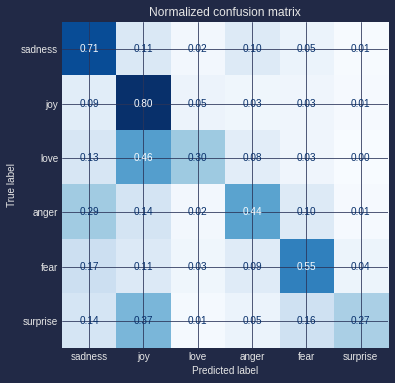

In [176]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
def plot_confusion_matrix(y_preds, y_true, labels):
  cm = confusion_matrix(y_true, y_preds, normalize="true")
  fig, ax = plt.subplots(figsize=(6, 6))
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
  disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
  plt.title("Normalized confusion matrix")
  plt.show()

labels=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']
y_preds = lr_clf.predict(X_valid)
plot_confusion_matrix(y_preds, y_valid, labels)

# Fine-Tuning Transformers

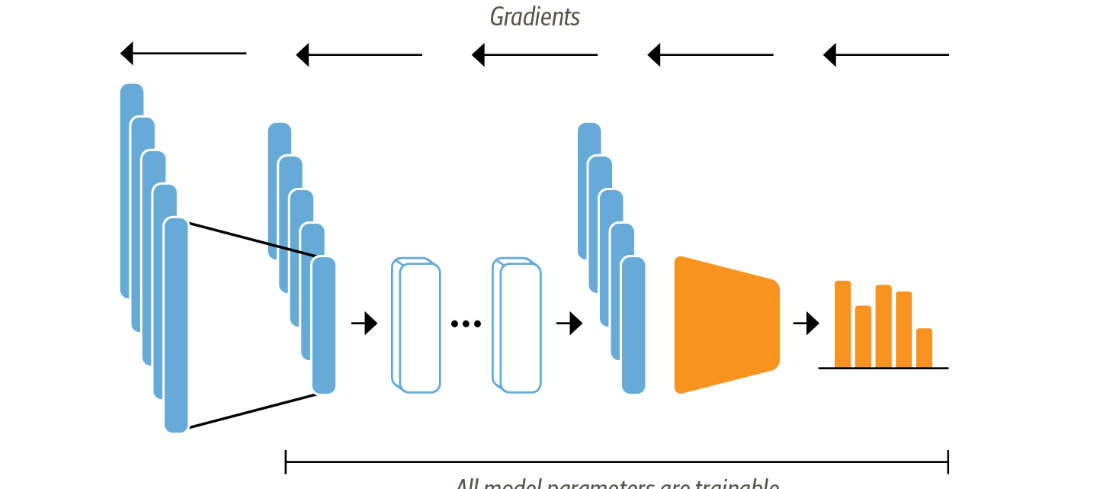

The first thing we need is a pretrained DistilBERT model like the one we used in the
feature-based approach. The only slight modification is that we use the AutoModelFor
SequenceClassification model instead of AutoModel. The difference is that the
AutoModelForSequenceClassification model has a classification head on top of the
pretrained model outputs, which can be easily trained with the base model. We just
need to specify how many labels the model has to predict (six in our case), since this
dictates the number of outputs the classification head has

In [177]:
#Loading a pretrained model DistilBERT model like the one we used in thefeature-based approach

from transformers import AutoModelForSequenceClassification
num_labels = 6
model = (AutoModelForSequenceClassification
.from_pretrained(model_ckpt, num_labels=num_labels)
.to(device))

In [178]:
# Defining the performance metrics

from sklearn.metrics import accuracy_score, f1_score
def compute_metrics(pred):
  labels = pred.label_ids
  preds = pred.predictions.argmax(-1)
  f1 = f1_score(labels, preds, average="weighted")
  acc = accuracy_score(labels, preds)
  return {"accuracy": acc, "f1": f1}

In [179]:
# log in huggingface_hub
from huggingface_hub import notebook_login
notebook_login()

In [180]:
from transformers import Trainer, TrainingArguments
batch_size = 64
logging_steps = len(emotions_encoded["train"]) // batch_size

model_name = f"{model_ckpt}-finetuned-emotion"

training_args = TrainingArguments(output_dir=model_name,
                                  num_train_epochs=5,
                                  learning_rate=2e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.01,
                                  evaluation_strategy="epoch",
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  push_to_hub=True,
                                  log_level="error")

In [181]:
from transformers import Trainer
trainer = Trainer(model=model, args=training_args,
                  compute_metrics=compute_metrics,
                  train_dataset=emotions_encoded["train"],
                  eval_dataset=emotions_encoded["validation"],
                  tokenizer=tokenizer)
trainer.train();

/content/distilbert-base-uncased-finetuned-emotion is already a clone of https://huggingface.co/Ahmed007/distilbert-base-uncased-finetuned-emotion. Make sure you pull the latest changes with `repo.git_pull()`.
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.762800,0.248851,0.915500,0.914140
2,0.201400,0.171600,0.928000,0.928289
3,0.135100,0.145583,0.937000,0.937439
4,0.104600,0.143983,0.935500,0.934877
5,0.087700,0.141274,0.937000,0.937233


In [182]:
preds_output = trainer.predict(emotions_encoded["validation"])

In [183]:
preds_output.metrics

{'test_accuracy': 0.937,
 'test_f1': 0.9372331942198677,
 'test_loss': 0.14127442240715027,
 'test_runtime': 4.521,
 'test_samples_per_second': 442.378,
 'test_steps_per_second': 7.078}

In [184]:
y_preds = np.argmax(preds_output.predictions, axis=1)

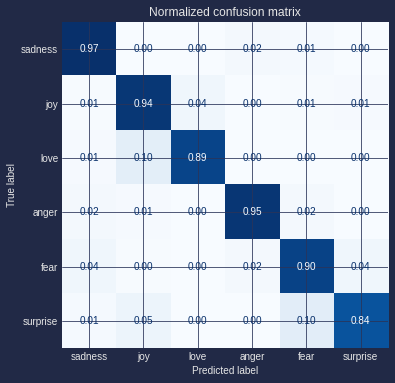

In [185]:
plot_confusion_matrix(y_preds, y_valid, labels)

In [186]:
# Error analysis

from torch.nn.functional import cross_entropy
def forward_pass_with_label(batch):
  # Place all input tensors on the same device as the model
  inputs = {k:v.to(device) for k,v in batch.items()
  if k in tokenizer.model_input_names}
  with torch.no_grad():
    output = model(**inputs)
  pred_label = torch.argmax(output.logits, axis=-1)
  loss = cross_entropy(output.logits, batch["label"].to(device),
  reduction="none")
  # Place outputs on CPU for compatibility with other dataset columns
  return {"loss": loss.cpu().numpy(),
  "predicted_label": pred_label.cpu().numpy()}

In [187]:
# Convert our dataset back to PyTorch tensors
emotions_encoded.set_format("torch",
columns=["input_ids", "attention_mask", "label"])
# Compute loss values
emotions_encoded["validation"] = emotions_encoded["validation"].map(
forward_pass_with_label, batched=True, batch_size=16)

Loading cached processed dataset at /root/.cache/huggingface/datasets/emotion/default/0.0.0/348f63ca8e27b3713b6c04d723efe6d824a56fb3d1449794716c0f0296072705/cache-1c80317fa3b1799d.arrow


In [188]:
emotions_encoded.set_format("pandas")
cols = ["text", "label", "predicted_label", "loss"]
df_test = emotions_encoded["validation"][:][cols]
df_test["label"] = df_test["label"].apply(label_int2str)
df_test["predicted_label"] = (df_test["predicted_label"].apply(label_int2str))

In [189]:
df_test.sort_values("loss", ascending=False).head(10)

,text,label,predicted_label,loss
1274,i am going to several holiday parties and i ca...,joy,sadness,5.185748
1950,i as representative of everything thats wrong ...,surprise,sadness,5.182365
882,i feel badly about reneging on my commitment t...,love,sadness,5.158078
1801,i feel that he was being overshadowed by the s...,love,sadness,5.141613
1963,i called myself pro life and voted for perry w...,joy,sadness,4.980229
465,i would eventually go in to these stores but i...,joy,fear,4.975656
1509,i guess this is a memoir so it feels like that...,joy,fear,4.807631
1870,i guess i feel betrayed because i admired him ...,joy,sadness,4.787856
765,i feel super awkward and out of place right now,joy,sadness,4.731141
1500,i guess we would naturally feel a sense of lon...,anger,sadness,4.620309


In [190]:
# let's see 
df_test.sort_values("loss", ascending=True).head(10)

,text,label,predicted_label,loss
1531,i forgive stanley hes not so quick to forgive ...,sadness,sadness,0.017998
625,i feel unwelcome in this town as if my time he...,sadness,sadness,0.018188
392,i remember feeling disheartened one day when w...,sadness,sadness,0.018280
697,i was missing him desperately and feeling idio...,sadness,sadness,0.018321
244,im kinda relieve but at the same time i feel d...,sadness,sadness,0.018465
1041,i suppose it all goes along with feeling unwel...,sadness,sadness,0.018480
1861,im tired of feeling lethargic hating to work o...,sadness,sadness,0.018558
69,i have no extra money im worried all of the ti...,sadness,sadness,0.018611
323,im starting to feel unwelcome in there,sadness,sadness,0.018624
189,i leave the meeting feeling more than a little...,sadness,sadness,0.018627


In [191]:
# Saving and sharing the model
# my first time  
trainer.push_to_hub(commit_message="Training completed!")

Several commits (2) will be pushed upstream.
The progress bars may be unreliable.


Upload file pytorch_model.bin:   0%|          | 3.34k/255M [00:00<?, ?B/s]

Upload file runs/Jul11_22-11-03_7fed312e62b7/events.out.tfevents.1657577466.7fed312e62b7.72.2:  50%|#####     …

To https://huggingface.co/Ahmed007/distilbert-base-uncased-finetuned-emotion
   7e26aef..ba24695  main -> main

To https://huggingface.co/Ahmed007/distilbert-base-uncased-finetuned-emotion
   ba24695..f1eafa4  main -> main



'https://huggingface.co/Ahmed007/distilbert-base-uncased-finetuned-emotion/commit/ba246957cbf0c6b41523720079717630f22e6126'

In [192]:
from transformers import pipeline
# Change `transformersbook` to your Hub username
model_id = "transformersbook/distilbert-base-uncased-finetuned-emotion"
classifier = pipeline("text-classification", model=model_id)